# Imports

In [105]:
import pandas as pd
import json
import seaborn as sns
import numpy as np
import matplotlib.pyplot as plt
pd.set_option('display.max_columns', None)

# Load Data

Viewing the first two lines in the file to understand more about the data structure.

In [43]:
with open("transactions.txt") as file:
    head = [next(file) for x in range(2)]
print(head)

['{"accountNumber": "733493772", "customerId": "733493772", "creditLimit": 5000.0, "availableMoney": 5000.0, "transactionDateTime": "2016-01-08T19:04:50", "transactionAmount": 111.33, "merchantName": "Lyft", "acqCountry": "US", "merchantCountryCode": "US", "posEntryMode": "05", "posConditionCode": "01", "merchantCategoryCode": "rideshare", "currentExpDate": "04/2020", "accountOpenDate": "2014-08-03", "dateOfLastAddressChange": "2014-08-03", "cardCVV": "492", "enteredCVV": "492", "cardLast4Digits": "9184", "transactionType": "PURCHASE", "isFraud": true, "echoBuffer": "", "currentBalance": 0.0, "merchantCity": "", "merchantState": "", "merchantZip": "", "cardPresent": false, "posOnPremises": "", "recurringAuthInd": "", "expirationDateKeyInMatch": false}\n', '{"accountNumber": "733493772", "customerId": "733493772", "creditLimit": 5000.0, "availableMoney": 4888.67, "currentBalance": 111.33, "transactionDateTime": "2016-01-09T22:32:39", "transactionAmount": 24.75, "merchantName": "Uber", "

The file contains a JSON data structure on each line. To load this, I will loop through each line and use the json library to load each one. This way, they are loaded as dictionaries rather than strings.

In [37]:
transactions=[]
with open("transactions.txt") as file:
    for line in file:
        transactions.append(json.loads(line))

In [38]:
len(transactions)

641914

Transform the data into a pandas dataframe to make it easier to work with.

In [41]:
df = pd.DataFrame(transactions)

In [ ]:
df.head()

In [45]:
df.shape

(641914, 29)

# Check Data Types

In [ ]:
df.dtypes

Transform column data types to make them easier to work with.

In [59]:
for col in ['transactionDateTime','currentExpDate','accountOpenDate','dateOfLastAddressChange']:
    df[col] = pd.to_datetime(df[col])

In [98]:
for col in df.select_dtypes(include=['bool']).columns:
    df[col] = df[col].astype(int)

# Check Label Imbalance

The data is very imbalanced so I will need to use some technique to address this later.

In [173]:
df.isFraud.value_counts()

0    630612
1     11302
Name: isFraud, dtype: int64

In [174]:
df.isFraud.value_counts() / len(df)

0    0.982393
1    0.017607
Name: isFraud, dtype: float64

# Data Completeness

In [ ]:
df.nunique()

In [ ]:
df.isnull().sum()

In [79]:
for col in df.columns[df.nunique() == 1]:
    print(f"{col} {df[col].value_counts().index}")

echoBuffer Index([''], dtype='object')
merchantCity Index([''], dtype='object')
merchantState Index([''], dtype='object')
merchantZip Index([''], dtype='object')
posOnPremises Index([''], dtype='object')
recurringAuthInd Index([''], dtype='object')


Drop columns that are empty

In [81]:
df.drop(columns=df.columns[df.nunique() == 1],inplace=True)

After dropping the empty columns, only a few categorical columns contain blanks. These will be encoded later so do not need to be filled in. If I had access to the source data I might spend some time investigating why these are empty.

In [ ]:
for col in df.columns:
    print(col)
    print(df[df[col]==''][col].count())

# Check unique values / cardinality

Checking that each account number is associated to a single customer ID, and how many cardCVV or cardLast4Digits can be associated to an account.

In [85]:
df.groupby('accountNumber').customerId.nunique().max()

1

In [86]:
df.groupby(['accountNumber']).cardCVV.nunique().max()

5

In [87]:
df.groupby(['accountNumber']).cardLast4Digits.nunique().max()

5

In [110]:
df.select_dtypes(include=['object']).nunique()

accountNumber           5000
customerId              5000
merchantName            2493
acqCountry                 5
merchantCountryCode        5
posEntryMode               6
posConditionCode           4
merchantCategoryCode      19
cardCVV                  899
enteredCVV               980
cardLast4Digits         5134
transactionType            4
dtype: int64

# Numerical Features Distribution

In [175]:
df.describe()

,creditLimit,availableMoney,transactionAmount,isFraud,currentBalance,cardPresent,expirationDateKeyInMatch
count,641914.000000,641914.000000,641914.000000,641914.000000,641914.000000,641914.000000,641914.000000
mean,10697.210608,6652.828573,135.162497,0.017607,4044.382035,0.469628,0.001510
std,11460.359133,9227.132275,147.053302,0.131517,5945.510224,0.499077,0.038824
min,250.000000,-1244.930000,0.000000,0.000000,0.000000,0.000000,0.000000
25%,5000.000000,1114.970000,32.320000,0.000000,502.442500,0.000000,0.000000
50%,7500.000000,3578.165000,85.800000,0.000000,2151.860000,0.000000,0.000000
75%,15000.000000,8169.185000,189.030000,0.000000,5005.890000,1.000000,0.000000
max,50000.000000,50000.000000,1825.250000,1.000000,47496.500000,1.000000,1.000000


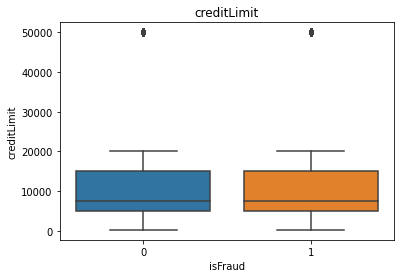

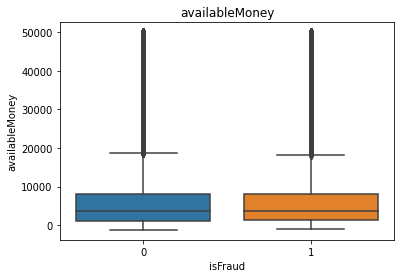

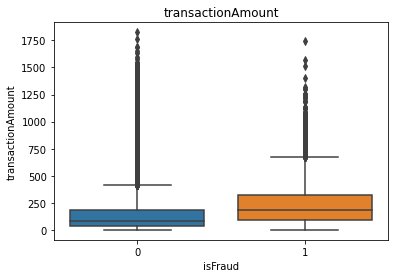

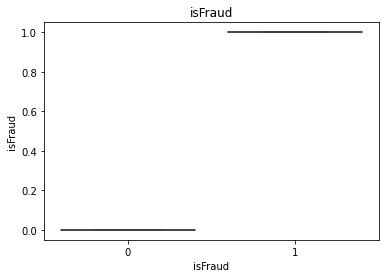

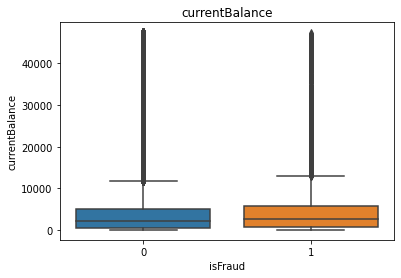

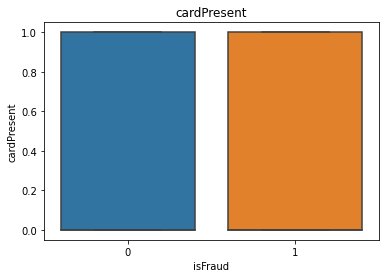

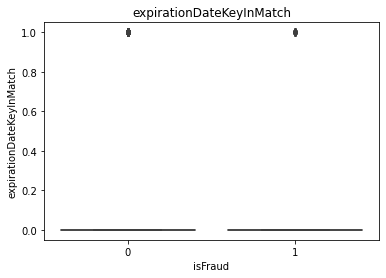

In [221]:
for col in df.select_dtypes("number").columns:
#     sns.distplot(df[col])
    sns.boxplot(x="isFraud", y=col, data=df)
    plt.title(f"{col}")
    plt.show()

# Correlation Plot

Checking the correlation to see if:

1. Any features are correlated which may interfere with model performance (depending on model type)
2. Which features look strongly correlated with target

Text(0.5, 1.0, 'correlation between numeric variables')

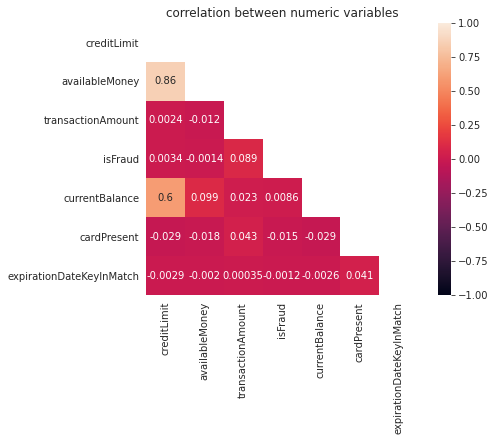

In [109]:
corr = df.corr()
mask = np.zeros_like(corr)
mask[np.triu_indices_from(mask)] = True
with sns.axes_style("white"):
    f, ax = plt.subplots(figsize=(7, 5))
    ax = sns.heatmap(corr, mask=mask, vmin=-1, vmax=1, annot=True, square=True)
plt.title('correlation between numeric variables')

# Categorical Feature Plot

Plotting graphs to show:

1. Fraud rate sliced by categorical feature: This will allow us to see any categorical features where a particular group has a stand-out fraud rate.
2. Count per group: This will allow us to see any features that might be overrepresenting a particular group, for example the majority of records are from the US so this could cause bias in the model. Ideally we would want to collect more data from other countries.

(Only plotting categorical features with less than 20 unique values otherwise the graphs can become incomprehensible).

In [162]:
cols_to_plot = [col for col in df.columns if col in df.columns[(df.nunique() <20)] 
                and col in df.select_dtypes('object').columns]

In [163]:
cols_to_plot

['acqCountry',
 'merchantCountryCode',
 'posEntryMode',
 'posConditionCode',
 'merchantCategoryCode',
 'transactionType']

In [248]:
def plot_fraud_rate(col):
    print(f"----------{col}----------")
    avg_fraud = df.groupby(col).isFraud.mean()
    count_records = df.groupby(col).accountNumber.count()
    plt.figure(figsize=(10,5))
    g=sns.scatterplot(x=avg_fraud.index, y=avg_fraud.values,marker='x',s=100)
    g.set_ylim(bottom=0)
    g2=g.twinx()
    g2=sns.barplot(x=count_records.index,y=count_records.values,alpha=0.2)
    for label in g.get_xticklabels():
        label.set_rotation(45)
    plt.title(col)
    plt.show()

----------acqCountry----------


/Users/zoe.aldington/opt/anaconda3/lib/python3.7/site-packages/seaborn/relational.py:651: UserWarning: You passed a edgecolor/edgecolors ('w') for an unfilled marker ('x').  Matplotlib is ignoring the edgecolor in favor of the facecolor.  This behavior may change in the future.
  points = ax.scatter(*args, **kws)


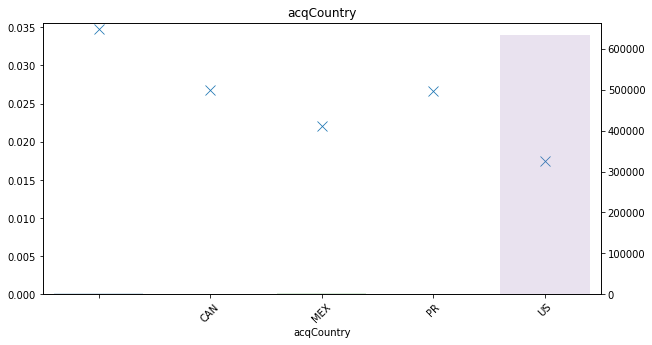

----------merchantCountryCode----------


/Users/zoe.aldington/opt/anaconda3/lib/python3.7/site-packages/seaborn/relational.py:651: UserWarning: You passed a edgecolor/edgecolors ('w') for an unfilled marker ('x').  Matplotlib is ignoring the edgecolor in favor of the facecolor.  This behavior may change in the future.
  points = ax.scatter(*args, **kws)


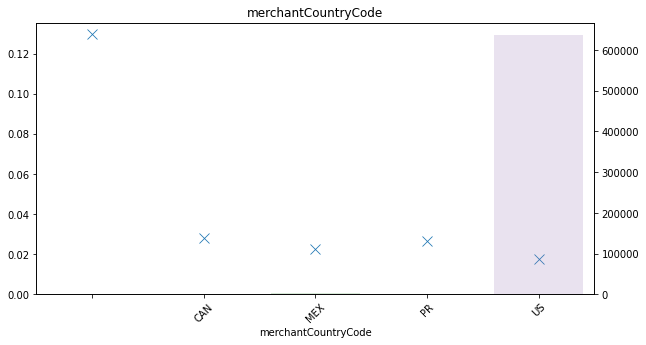

----------posEntryMode----------


/Users/zoe.aldington/opt/anaconda3/lib/python3.7/site-packages/seaborn/relational.py:651: UserWarning: You passed a edgecolor/edgecolors ('w') for an unfilled marker ('x').  Matplotlib is ignoring the edgecolor in favor of the facecolor.  This behavior may change in the future.
  points = ax.scatter(*args, **kws)


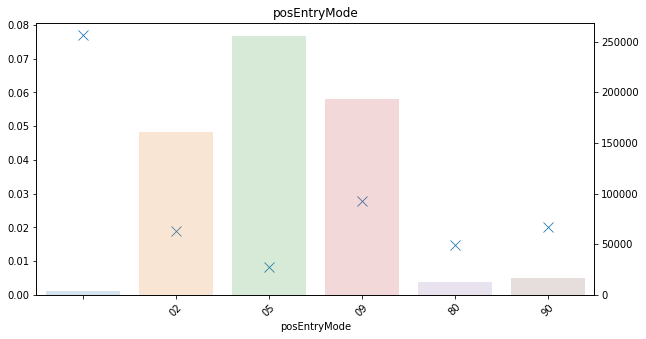

----------posConditionCode----------


/Users/zoe.aldington/opt/anaconda3/lib/python3.7/site-packages/seaborn/relational.py:651: UserWarning: You passed a edgecolor/edgecolors ('w') for an unfilled marker ('x').  Matplotlib is ignoring the edgecolor in favor of the facecolor.  This behavior may change in the future.
  points = ax.scatter(*args, **kws)


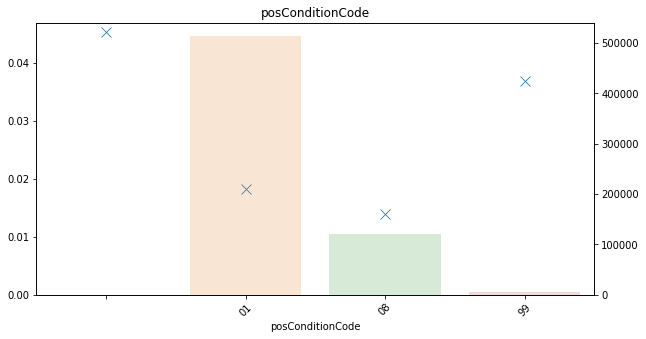

----------merchantCategoryCode----------


/Users/zoe.aldington/opt/anaconda3/lib/python3.7/site-packages/seaborn/relational.py:651: UserWarning: You passed a edgecolor/edgecolors ('w') for an unfilled marker ('x').  Matplotlib is ignoring the edgecolor in favor of the facecolor.  This behavior may change in the future.
  points = ax.scatter(*args, **kws)


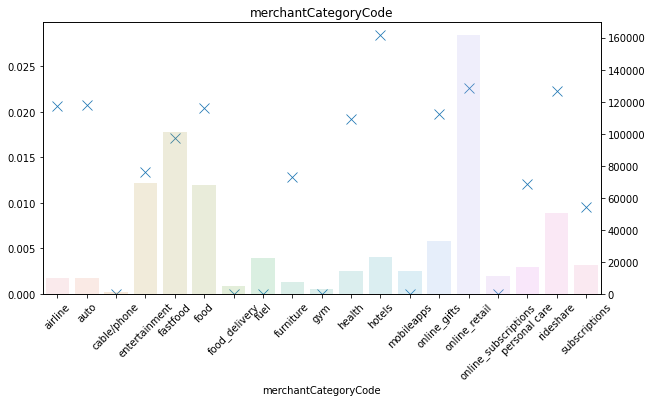

----------transactionType----------


/Users/zoe.aldington/opt/anaconda3/lib/python3.7/site-packages/seaborn/relational.py:651: UserWarning: You passed a edgecolor/edgecolors ('w') for an unfilled marker ('x').  Matplotlib is ignoring the edgecolor in favor of the facecolor.  This behavior may change in the future.
  points = ax.scatter(*args, **kws)


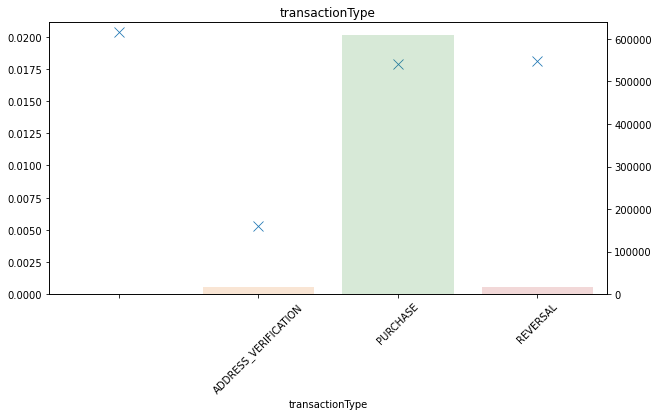

In [249]:
for col in cols_to_plot:
    plot_fraud_rate(col)

# Date Range

In [227]:
df['transactionDate'] = df['transactionDateTime'].dt.date

Text(0.5, 1.0, 'Transactions by Date')

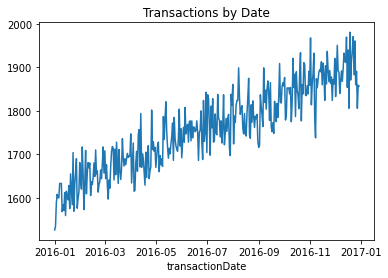

In [247]:
transactions_by_date = df.groupby('transactionDate').accountNumber.count()
sns.lineplot(x=transactions_by_date.index,y=transactions_by_date.values)
plt.title('Transactions by Date')

In [234]:
df['transactionHour'] = df['transactionDateTime'].dt.hour

Text(0.5, 1.0, 'Transactions by Hour of Day')

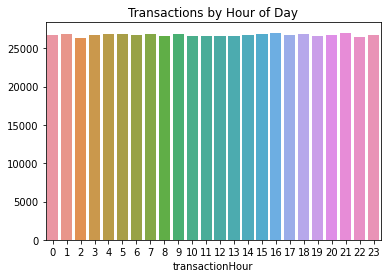

In [245]:
transactions_by_hour = df.groupby('transactionHour').accountNumber.count()
sns.barplot(x=transactions_by_hour.index,y=transactions_by_hour.values)
plt.title('Transactions by Hour of Day')

Text(0.5, 1.0, 'Fraudulent transactions by hour of day')

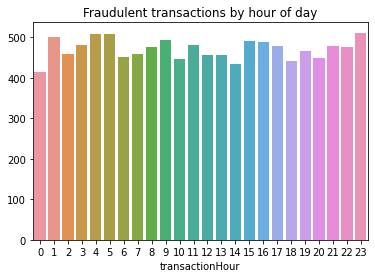

In [246]:
transactions_by_hour_fraud = df[df.isFraud==1].groupby('transactionHour').accountNumber.count()
sns.barplot(x=transactions_by_hour_fraud.index
             ,y=transactions_by_hour_fraud.values)
plt.title('Fraudulent transactions by hour of day')

# Pandas Profiling

In [220]:
# from pandas_profiling import ProfileReport
# profile = ProfileReport(df, title="Pandas Profiling Report", explorative=True)
# profile.to_widgets()

# Save Model Data

In [250]:
df.shape

(641914, 25)

In [ ]:
df.head()

In [252]:
df.to_csv('transactions_data.csv',index=False)